In [57]:
import  numpy as np
import os
import string
import sys
from matplotlib import pyplot as plt  
import os, os.path

def LQ(A): #triangularizarea la dreapta cu reflectori hermitici 
    m,n  = np.shape(A)
    s = min(m,n)
    
    beta = np.zeros(s)

    for k in range(s):
        beta[k] = 0
        if k<n:
            sigma = np.linalg.norm(A[k,k:n])
            if sigma!=0:
                if A[k,k] !=0:
                    sigma = sigma * A[k,k]/np.absolute(A[k,k])
                for j in range(k,n):
                    A[k,j] = A[k,j]/sigma
                beta[k] = 1 + A[k,k]
                for i in range(k+1,m):
                    sum = 0
                    for j in range(k,n):
                        sum += A[i,j] * A[k,j]
                    alfa = -1*sum/beta[k]
                    for j in range(k,n):
                        A[i,j] += alfa*A[k,j]
                A[k,k] = -sigma
    return A, beta
    
def SQL(A, b, beta): #rezolvarea sistemelor subdeterminate
    m,n  = np.shape(A)
    x = np.zeros(n)
    
    for k in range(m):
        sum = 0
        for j in range(k-1):
            sum += A[k,j]*x[j]
        x[k] = (b[k] - sum)/A[k,k]
    
    #calculul solutiei normale
    x[m+1:n] = 0
    for k in range(m-1,-1,-1):
        t = A[k,k]
        A[k,k] = beta[k]
        sum = 0
        for j in range(k,n):
            sum+=A[k,j]*x[j]
        alfa = -sum/beta[k]
        for j in range(k,n):
            x[j]+=alfa*A[k,j]
        A[k,k] = t
    return x
        

In [58]:
#citeste cuvintele din dictionar in vectorul "dictionar"
dictionar = np.loadtxt("dictionar\dictionar2.txt", dtype=str)
#d = dimensiune vector dictionar
d = dictionar.size

#salveaza numarul de fisiere din fiecare folder in parte
path = 'date_antrenare\mail_bun'
nr_mail_antrenare_bun = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
path = 'date_antrenare\mail_spam'
nr_mail_antrenare_spam = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])

nr_total_mailuri_antrenare = nr_mail_antrenare_bun + nr_mail_antrenare_spam

#initializeaza matrice features(dim 10 X d+1)
features = np.zeros((nr_total_mailuri_antrenare, d + 1))   #ultima coloana = 1

#initializeaza vectorul labels de dim n*1(n mailuri, fiecare mail este bun(1) sau spam(-1))
labels = np.zeros(nr_total_mailuri_antrenare)

#pentru mail-urile bune
for i in range(nr_mail_antrenare_bun):
    features[i, d] = 1 #ultima coloana este 1
    labels[i] = 1      #mail bun (1)               

    with open("date_antrenare\mail_bun\\" + str(i) + '.txt','r') as file:   #deschide fisierul "nr_mail.txt"
        # citeste fiecare linie    
        for line in file:
            # citeste fiecare cuvant din mail        
            for word in line.split():
                #cauta daca cuvantul se gaseste in dictionar
                 for j in range(d):               
                        if(word.lower() == dictionar[j]): #daca cuvantul este gasit
                            features[i, j] += 1 #incrementeaza cu 1 nr de aparitii
                            break #iesi din for

#pentru mail-urille spam
#se pleaca cu indexul de la nr_mail_antrenare_bun
for i in range(nr_mail_antrenare_bun, nr_total_mailuri_antrenare):
    features[i, d] = 1 #ultima linie este 1
    labels[i] = -1      #mail spam (-1)       
    with open("date_antrenare\mail_spam\\" + str(i - nr_mail_antrenare_bun) + '.txt','r') as file:   #deschide fisierul "nr_mail.txt"
        # citeste fiecare linie    
        for line in file:
            # citeste fiecare cuvant din mail        
            for word in line.split():
                 #cauta daca cuvantul se gaseste in dictionar
                 for j in range(d):                 
                        if(word.lower() == dictionar[j]):#daca cuvantul este gasit
                            features[i, j] += 1 #incrementeaza nr de aparitii
                            break #iesi din for
#features
#labels



In [59]:
#date de testare:

path = 'date_testare'
nr_mail_testare = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])

test_features = np.zeros([nr_mail_testare, d])

for i in range(nr_mail_testare):
    with open("date_testare\\" + str(i) + '.txt','r') as file:   #deschide fisierul cu mailul de testare
            # citeste fiecare linie    
            for line in file:
                # citeste fiecare cuvant din mail        
                for word in line.split():
                    #cauta daca cuvantul se gaseste in dictionar
                     for j in range(d):                       
                            if(word.lower() == dictionar[j]):
                                test_features[i, j] += 1 #nr de aparitii
                                break

    

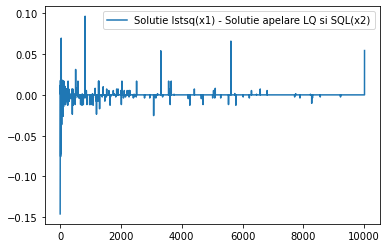

mail_antrenament1:  1.0000000000000002
mail_antrenament2:  0.9999999999999987
mail_antrenament3:  1.0000000000000007
mail_antrenament4:  1.0000000000000009
mail_antrenament5:  1.0000000000000013
mail_antrenament6:  -0.9999999999999944
mail_antrenament7:  -0.9999999999999949
mail_antrenament8:  -1.0
mail_antrenament9:  -0.9999999999999991
mail_antrenament10:  -1.0000000000000078


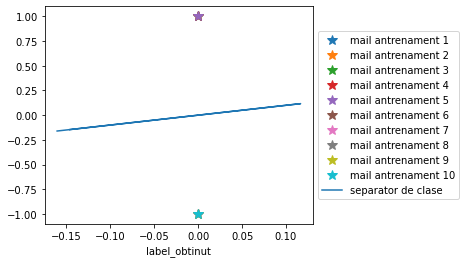

----test_mails----
Mail de test 1  - 0.6885976144338388 clasificat ca fiind bun
Mail de test 2  - 0.9102005250464336 clasificat ca fiind bun
Mail de test 3  - -1.628522013000586 clasificat ca fiind spam
Mail de test 4  - -0.3618066647051697 clasificat ca fiind spam


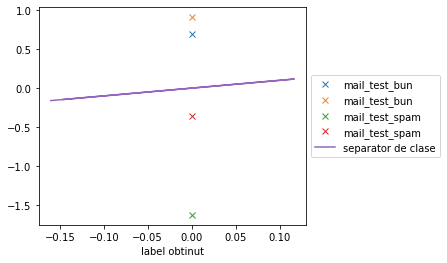

In [60]:
#Se contruieste clasificatorul
# sistemul este supradeterminat => cautam solutia CMMP
A = np.copy(features)

#prima data rezolva sistemul cu functia lianlg.lstsq
x1 = np.linalg.lstsq(features, labels, rcond=None)[0]

#clasificatorul obtinut este de forma: f(v) = c' * v + p
#la noi c = x[:d]si p = x[d]                         
                                                 
x2 = np.transpose(features) @ np.linalg.inv(features @ np.transpose(features)) @ labels

L, beta = LQ(features)
x2 = SQL(L, labels, beta)
    
# grafic cu diferentele dintre apelarea lstsq si apelarea LQ + SQL
plt.plot(x1 - x2)
plt.legend(["Solutie lstsq(x1) - Solutie apelare LQ si SQL(x2)"])
plt.show()

#x1 = np.copy(x2)


# clasificare mailuri antrenare
for i in range(nr_total_mailuri_antrenare):
    label_mail = A[i,:d] @ x1[:d] + x1[d] #aplica clasificatorul pe mailul i
    plt.plot(label_mail,'*', label='mail antrenament '+ str(i+1), markersize=10)
    print('mail_antrenament' + str(i+1) + str(": "), label_mail)

plt.xlabel("label_obtinut")
plt.legend()

plt.plot(x1,x1, label='separator de clase')

#scrie legenda in afara graficului
ax = plt.subplot(111)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
    
    
#clasificare mailuri noi
print('----test_mails----')
for i in range(nr_mail_testare):
    label_mail = test_features[i,:] @ x1[:d] + x1[d] #aplica  clasificatorul
    if label_mail >= 0:
        string = 'bun'
    else:
        string = 'spam'
    plt.plot(label_mail, 'x' ,label='mail_test_'+ string)
    print('Mail de test ' + str(i + 1), " -", label_mail,'clasificat ca fiind '+ string)
    
plt.plot(x1,x1, label='separator de clase')

plt.legend()
plt.xlabel("label obtinut")
#scrie legenda in afara graficului
ax = plt.subplot(111)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

 